In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.plot_data as plot
import models.transforms as transforms
import algorithms.teaching_algs as algs
import evals.teaching_evals as evals
import utils.gen_triplets as gen

sns.set_theme()
def get_ci(samples, confidence=0.95):  return stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)
def get_lpips_data(dataset, seeds):    
    transform = transforms.bird_transform()
    train = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/train", transform=transform)
    test = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/test", transform=transform)
    x_train = np.array([x[0].numpy() for x in train])
    x_test = np.array([x[0].numpy() for x in test])
    y_train = np.array([x[1] for x in train])
    y_test = np.array([x[1] for x in test])

    dist_M = pickle.load(open(f"data/dist/lpips/{dataset}/train_test.pkl","rb"))
    zs = [pickle.load(open(f"data/embeds/bm_lpips/TN_train_d50_seed{seed}.pkl","rb")) for seed in seeds]

    return dist_M, zs, y_train, y_test

def get_prolific_data(dataset, seeds):    
    transform = transforms.bird_transform()
    train = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/train", transform=transform)
    test = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/test", transform=transform)
    x_train = np.array([x[0].numpy() for x in train])
    x_test = np.array([x[0].numpy() for x in test])
    y_train = np.array([x[1] for x in train])
    y_test = np.array([x[1] for x in test])

    dist_Ms = [pickle.load(open(f"data/dist/prolific/{dataset}/train_test_seed{seed}.pkl","rb")) for seed in seeds]
    zs = [pickle.load(open(f"data/embeds/{dataset}_prolific/TN_train_d50_seed{seed}.pkl","rb")) for seed in seeds]

    return dist_Ms, zs, y_train, y_test

## concat-embed experiments

In [2]:
def baseline_experiments(m_range, dist_M, teaching_alg, z, y_train, y_test, sim=True):
    def rand_score(dist_M, m, y_train, y_test, n_trials=1000):
        random_scores = np.array([evals.eval_KNN(dist_M, algs.random(y_train, m), y_train, y_test) for _ in range(n_trials)])
        random_ci = get_ci(random_scores)
        random_score = random_scores.mean()
        return random_score, random_ci

    def full_rand_score(m_range, dist_M, y_train, y_test):
        full_score = evals.eval_KNN(dist_M, np.arange(len(y_train)), y_train, y_test, k=1)
        random_scores = []
        random_cis = []
        for m in m_range:
            random_score, random_ci = rand_score(dist_M, m, y_train, y_test)
            random_scores.append(random_score)
            random_cis.append(random_ci)
        random_scores = np.array(random_scores)
        random_cis = np.array(random_cis)
        return full_score, random_scores

    full_scores, random_scores = full_rand_score(m_range, dist_M, y_train, y_test)
    nn_scores, nn_double_scores = np.zeros(len(m_range)), np.zeros(len(m_range))

    sim_M = evals.dist2sim(dist_M) if sim else dist_M
    for j, m in enumerate(m_range):
        S_single = teaching_alg(z, m)
        nn_scores[j] = evals.eval_KNN(sim_M, S_single, y_train, y_test, sim=True)
    for j, m in enumerate(m_range*2):
        S_single = teaching_alg(z, m)
        nn_double_scores[j] = evals.eval_KNN(sim_M, S_single, y_train, y_test, sim=True)

    results = {"full_scores": [full_scores]*len(m_range), 
        "random_scores": random_scores,
        "1NN_scores": nn_scores,
        "1NN_double_scores": nn_double_scores,
        }
    return results

def CV_experiments(m_range, dist_M, teaching_alg, paired_z, z, y_train, y_test, sim=True):
    CV_scores, wCV_scores, CV_abs = np.zeros(len(m_range)), np.zeros(len(m_range)), np.zeros(len(m_range))

    sim_M = evals.dist2sim(dist_M) if sim else dist_M
    paired_z, idx = paired_z
    for j, m in enumerate(m_range):
        S_concat = teaching_alg(paired_z, m)
        S_pairs = idx[S_concat]
        S_single = teaching_alg(z, m)
        CV_scores[j] = evals.eval_CV(sim_M, S_pairs, y_train, y_test, weighted=False, sim=sim)
        wCV_scores[j] = evals.eval_CV(sim_M, S_pairs, y_train, y_test, weighted=True, sim=sim)
        CV_abs[j] = evals.eval_CV_abs(sim_M, S_pairs, y_train, y_test, weighted=False, sim=sim)

    results = {
        "CV_scores": CV_scores,
        "wCV_scores": wCV_scores,
        "CV_abs_scores": CV_abs,
        }
    return results

In [3]:
alg_names = ["mmd_greedy"]
SIM = True
teaching_algs = [algs.mmd_greedy]
m_range = np.arange(1,12)

def plot_results(results, m_range, title, ste=None):
        legend = [score.replace("_scores","") for score in results]
        configs = {     "full_scores":          ["k", 2, "",  "dashed"], 
                        "random_scores":        ["y", 2, "",  "dashed"],
                        "1NN_scores":           ["c", 4, "o", "solid"],
                        "CV_scores":            ["r", 4, "s", "dashdot"],
                        "wCV_scores":           ["g", 4, "^", "dotted"],
                        "CV_abs_scores":            ["m", 4, "x", "solid"],
                        "1NN_double_scores":    ["b", 4, "*", "solid"],}

        sns.set_color_codes("bright")
        plt.figure(figsize=(14,8))
        for score in results.keys():
            config = configs[score]
            _ = plt.plot(m_range, results[score], alpha=0.8, markersize=10,
            color=config[0], lw=config[1], marker=config[2], linestyle=config[3])
            if ste is not None:
                plt.fill_between(m_range, results[score] + ste[score], results[score] - ste[score], color=config[0],alpha=0.5)


        plt.xticks(m_range)
        plt.xlabel("m")
        plt.legend(legend, loc="lower center", ncol=len(results))
        plt.title(title)

#### lpips data

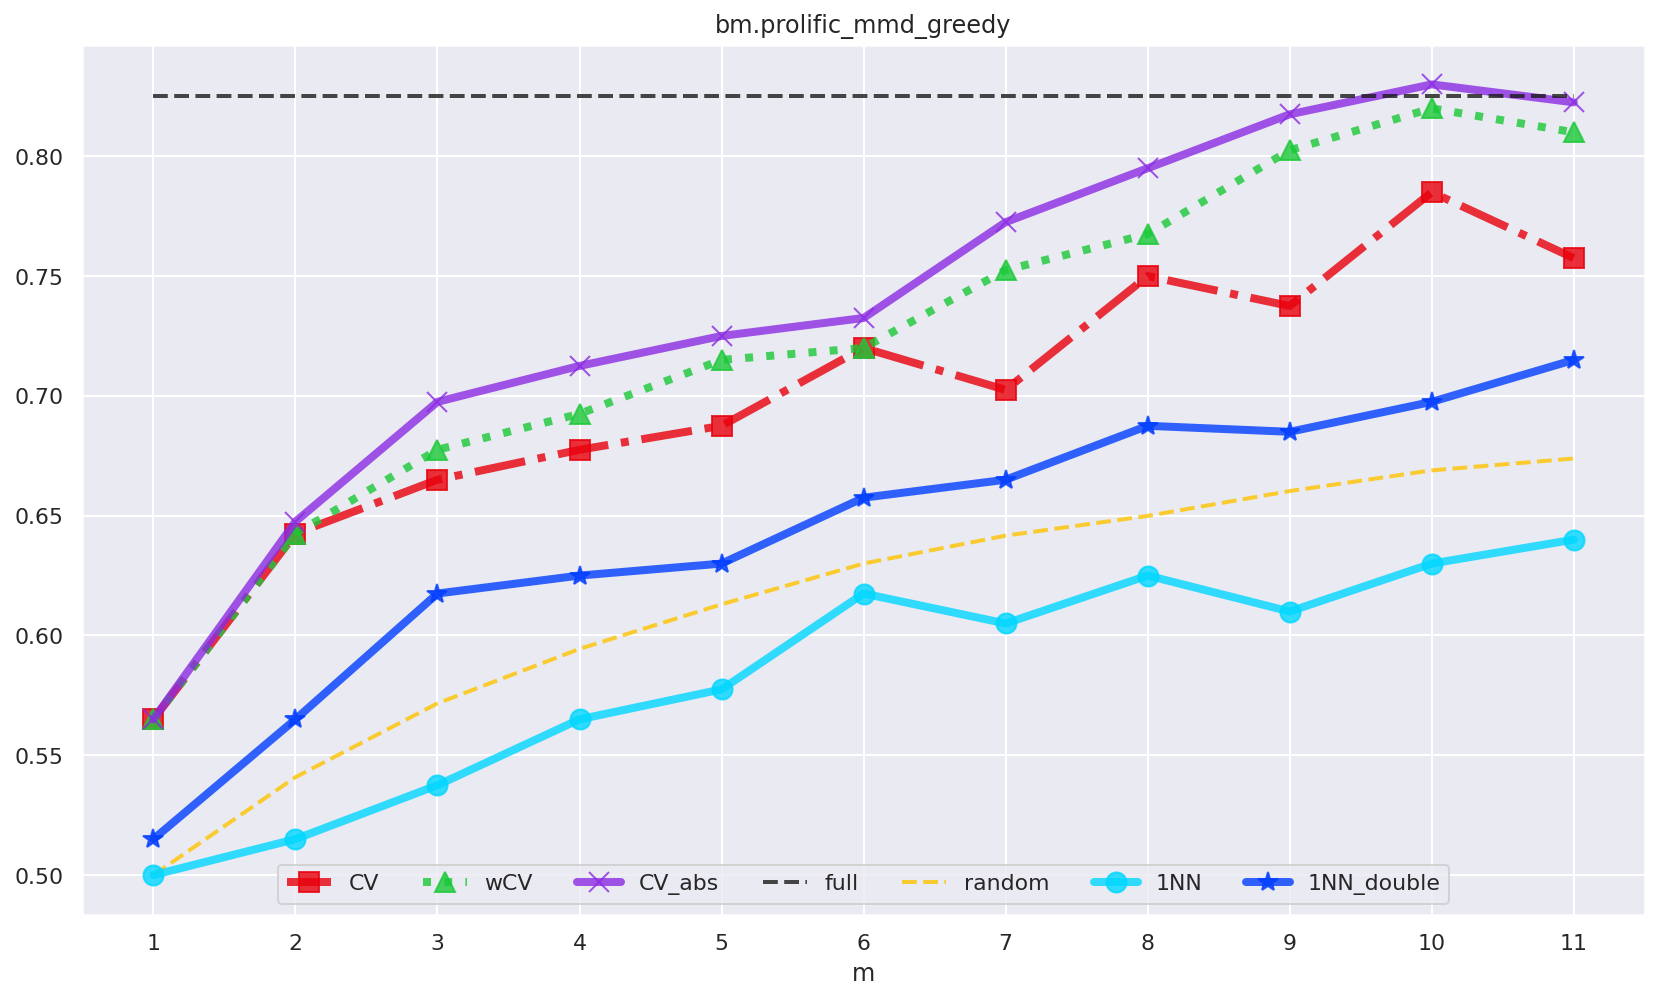

In [4]:
dataset = "bm"
seeds = np.arange(10)
dist_M, zs, y_train, y_test = get_lpips_data(dataset, seeds)
paired_zs = [evals.concat_embeds(z, y_train) for z in zs]
# paired_zs = [evals.diff_embeds(z, y_train) for z in zs]

for alg, alg_name in zip(teaching_algs, alg_names):
    CV_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z in zip(paired_zs, zs)]
    CV_acc = {key:np.mean(np.array([result[key] for result in CV_results]), axis=0) for key in CV_results[0].keys()}
    baseline_results = [baseline_experiments(m_range, dist_M, alg, z, y_train, y_test, sim=SIM) for paired_z, z in zip(paired_zs, zs)]
    baseline_acc = {key:np.mean(np.array([result[key] for result in baseline_results]), axis=0) for key in baseline_results[0].keys()}
    plot_results({**CV_acc, **baseline_acc}, m_range, f"{dataset}.prolific_{alg_name}")

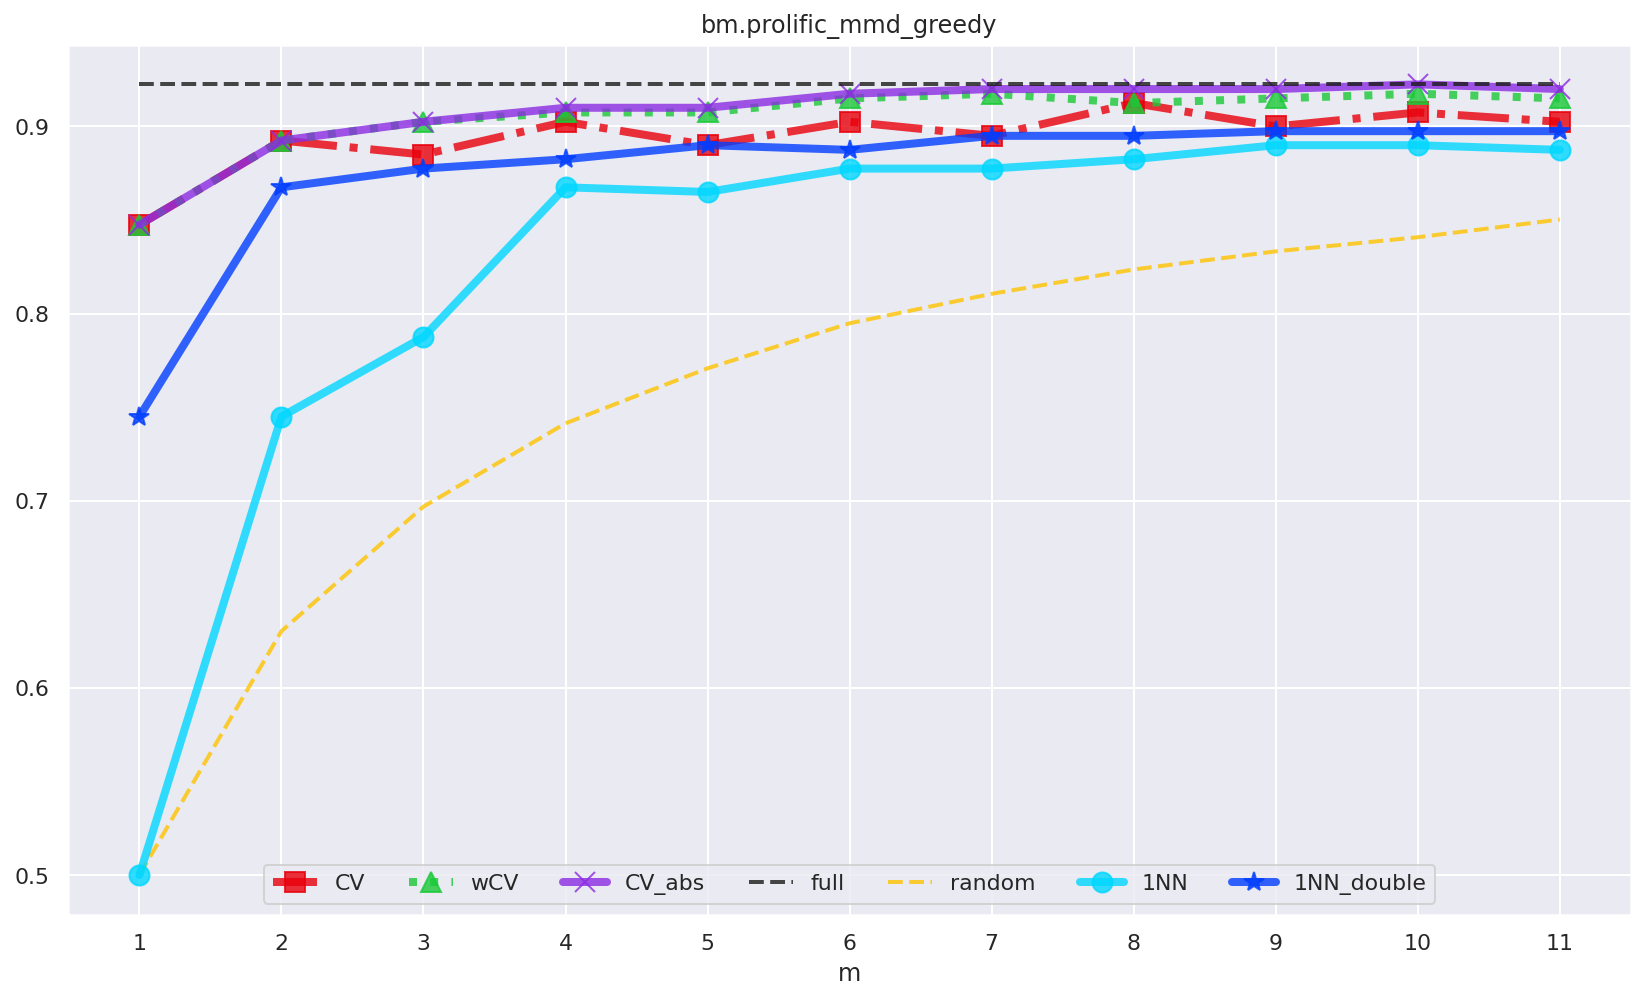

In [5]:
dataset = "bm"
seeds = np.arange(10)
dist_Ms, zs, y_train, y_test = get_prolific_data(dataset, seeds)
paired_zs = [evals.concat_embeds(z, y_train) for z in zs]

for alg, alg_name in zip(teaching_algs, alg_names):
    CV_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z, dist_M in zip(paired_zs, zs, dist_Ms)]
    CV_acc = {key:np.mean(np.array([result[key] for result in CV_results]), axis=0) for key in CV_results[0].keys()}
    baseline_results = [baseline_experiments(m_range, dist_M, alg, z, y_train, y_test, sim=SIM) for z, dist_M in zip(zs, dist_Ms)]
    baseline_acc = {key:np.mean(np.array([result[key] for result in baseline_results]), axis=0) for key in baseline_results[0].keys()}
    plot_results({**CV_acc, **baseline_acc}, m_range, f"{dataset}.prolific_{alg_name}")

### DIFF vs. CONCAT

In [6]:
def plot_concat_diff(concat_acc, diff_acc, m_range, title):
    legend = ['CV_CONCAT', 'CV_DIFF', 'wCV_CONCAT', 'wCV_DIFF', 'CV_abs_CONCAT', 'CV_abs_DIFF']
    configs = {
                    "CV_scores":            ["r", 4, "s", "dashdot"],
                    "wCV_scores":           ["g", 4, "^", "dotted"],
                    "CV_abs_scores":            ["k", 4, "x", "solid"]}

    sns.set_color_codes("bright")
    plt.figure(figsize=(14,8))
    for score in concat_acc.keys():
        config = configs[score]
        _ = plt.plot(m_range, concat_acc[score], alpha=0.8,
        color=config[0], lw=config[1],linestyle="solid")
        _ = plt.plot(m_range, diff_acc[score], alpha=0.8,
        color=config[0], lw=config[1],linestyle="dotted")


    plt.xticks(m_range)
    plt.xlabel("m")
    plt.legend(legend, loc="lower center", ncol=len(concat_acc))
    plt.title(title)

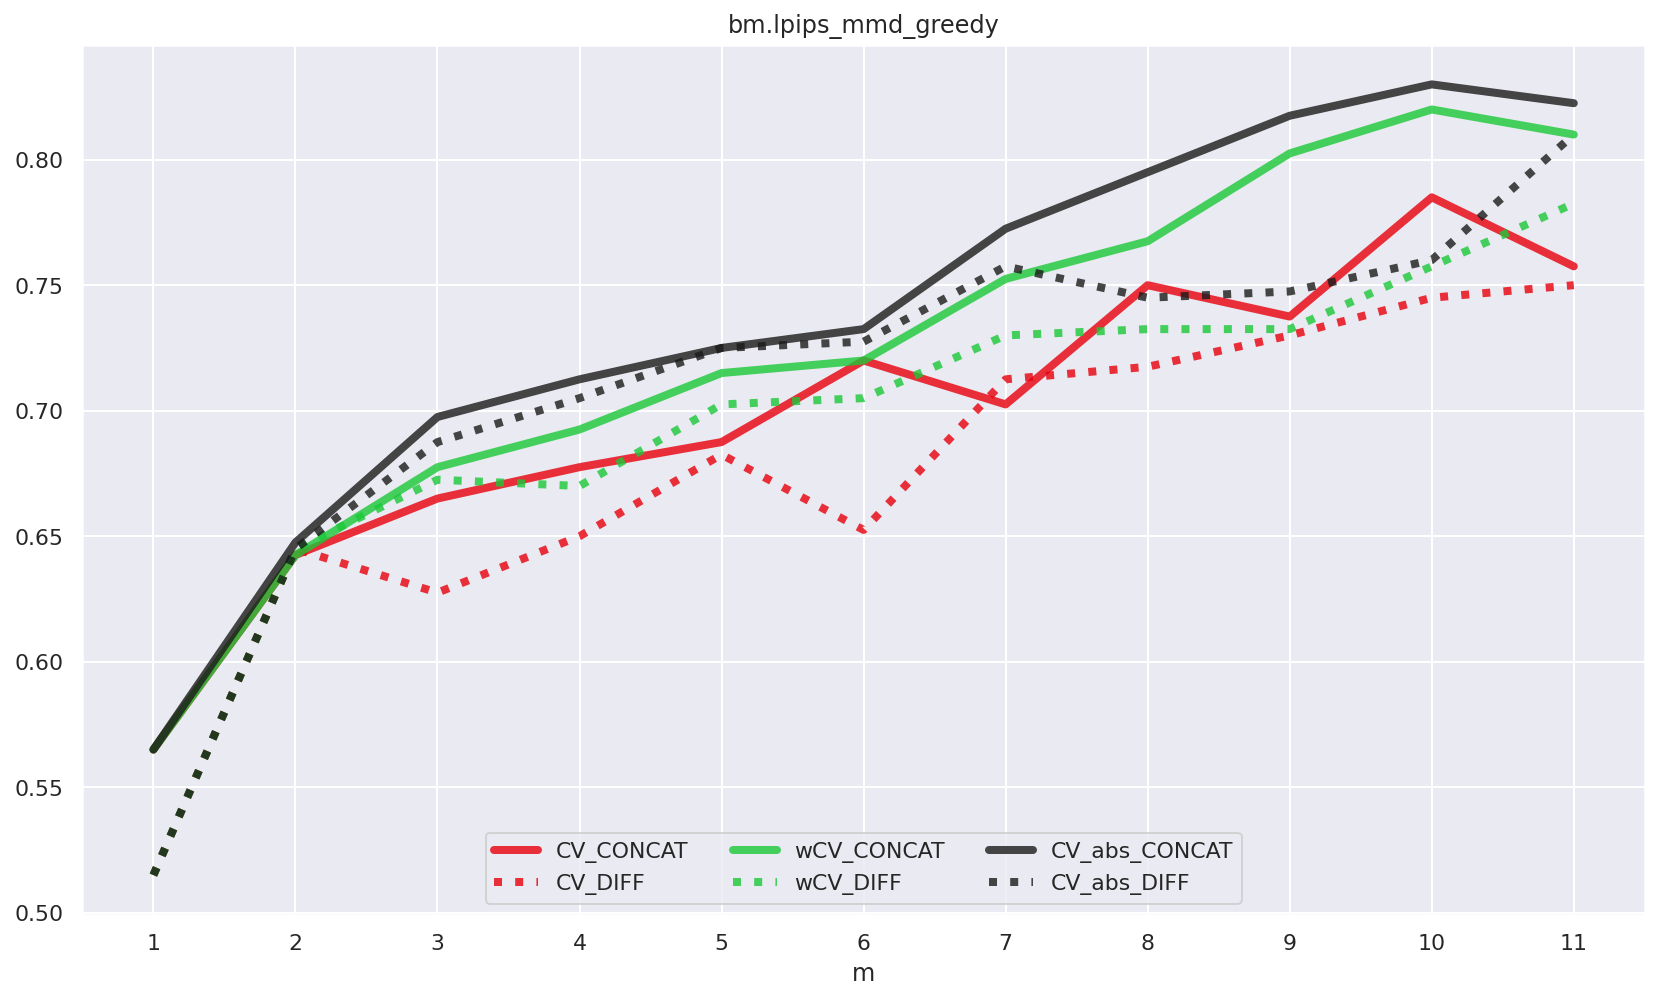

In [7]:
dataset = "bm"
seeds = np.arange(10)
dist_M, zs, y_train, y_test = get_lpips_data(dataset, seeds)
concat_zs = [evals.concat_embeds(z, y_train) for z in zs]
diff_zs = [evals.diff_embeds(z, y_train) for z in zs]

for alg, alg_name in zip(teaching_algs, alg_names):
    concat_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z in zip(concat_zs, zs)]
    diff_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z in zip(diff_zs, zs)]
    concat_acc = {key:np.mean(np.array([result[key] for result in concat_results]), axis=0) for key in concat_results[0].keys()}
    diff_acc = {key:np.mean(np.array([result[key] for result in diff_results]), axis=0) for key in diff_results[0].keys()}
    plot_concat_diff(concat_acc, diff_acc, m_range, f"{dataset}.lpips_{alg_name}")

11


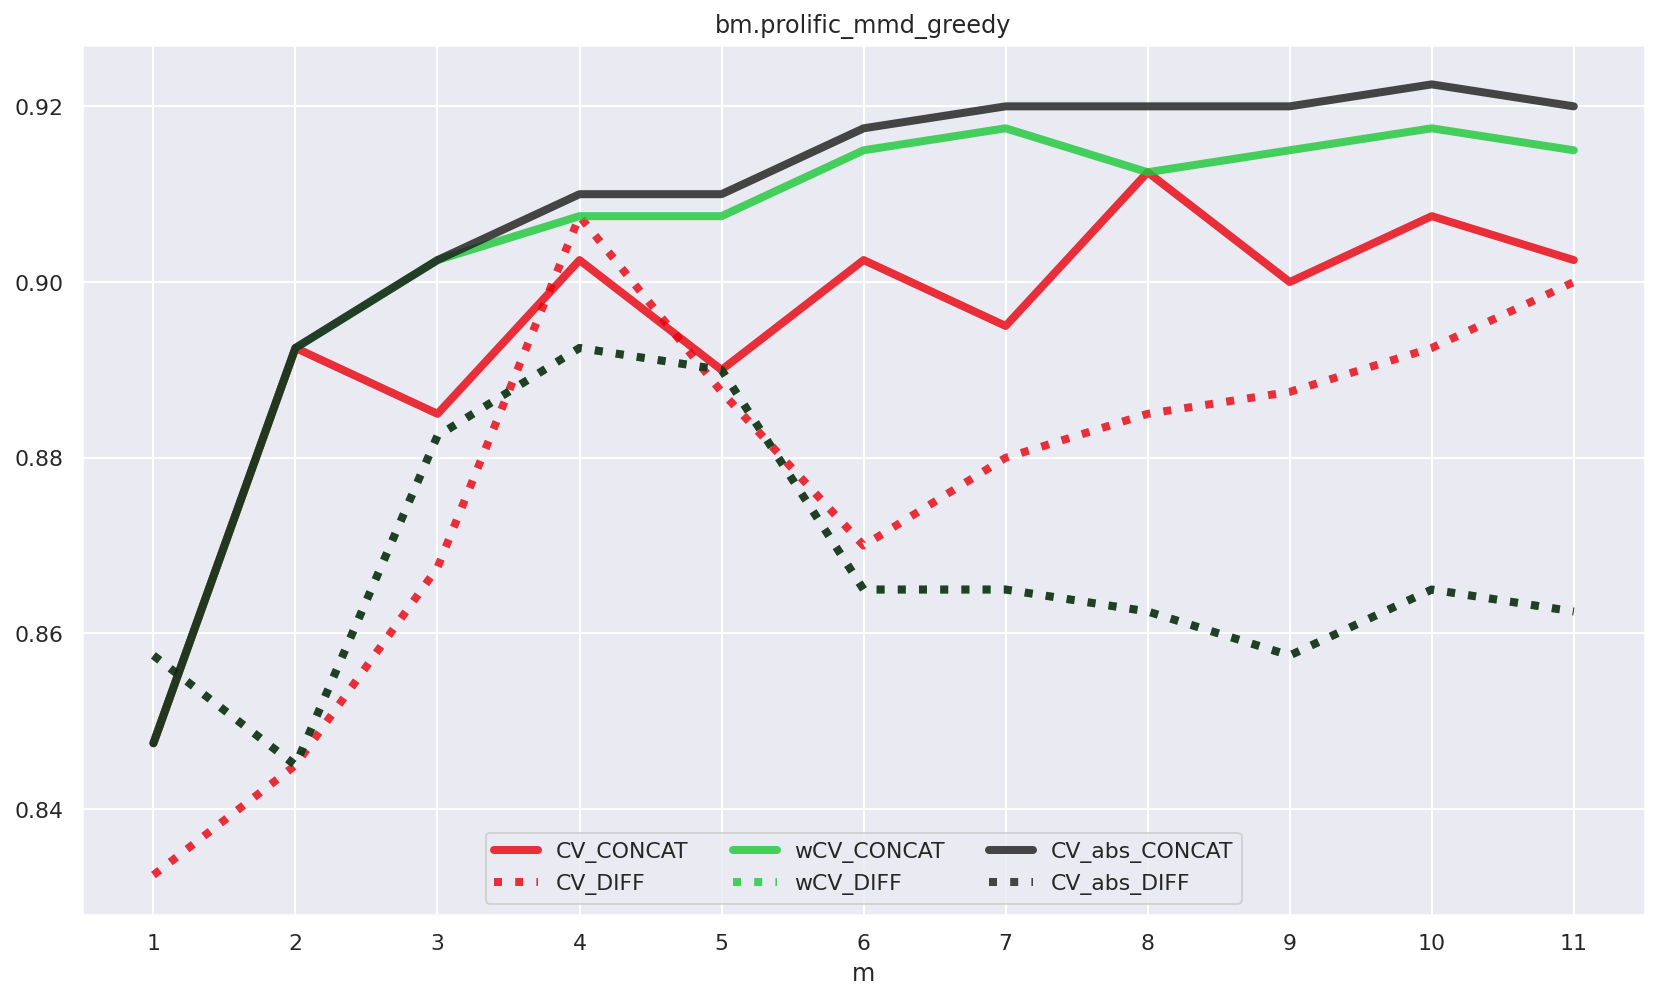

In [8]:
dataset = "bm"
seeds = np.arange(10)
dist_Ms, zs, y_train, y_test = get_prolific_data(dataset, seeds)
concat_zs = [evals.concat_embeds(z, y_train) for z in zs]
diff_zs = [evals.diff_embeds(z, y_train) for z in zs]

for alg, alg_name in zip(teaching_algs, alg_names):
    concat_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z, dist_M in zip(concat_zs, zs, dist_Ms)]
    print(11)
    diff_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z, dist_M in zip(diff_zs, zs, dist_Ms)]
    concat_acc = {key:np.mean(np.array([result[key] for result in concat_results]), axis=0) for key in concat_results[0].keys()}
    diff_acc = {key:np.mean(np.array([result[key] for result in diff_results]), axis=0) for key in diff_results[0].keys()}
    plot_concat_diff(concat_acc, diff_acc, m_range, f"{dataset}.prolific_{alg_name}")

In [9]:
stopstopstop

NameError: name 'stopstopstop' is not defined

In [ ]:
def eval_CV(M, pairs, y_train, y_test, weighted, sim=False):
    num_classes = len(np.unique(y_train))
    y_pred = [evals.contrastive_vote(pairs, row, y_train, num_classes, weighted, sim) for row in M]
          
    assert(len(y_pred)==len(y_test))

    return 1-(np.array(y_pred)==np.array(y_test)).sum()/len(y_test), y_pred
sim_M = evals.dist2sim(dist_M)
concat_z, idx = evals.concat_embeds(z, y_train)
S_concat = alg(concat_z, 5)
S_pairs = idx[S_concat]
c1, y1 = eval_CV(sim_M, S_pairs, y_train, y_test, weighted=False, sim=True)
c2, y2 = eval_CV(sim_M, S_pairs, y_train, y_test, weighted=True, sim=True)
y1==y2

In [ ]:
def normalize(data):return (data-np.min(data)) / (np.max(data)-np.min(data))
x = 1/lpips_test

In [ ]:
S1, S2 = algs.kmedoids_contrastive(X, y_train, m)
pairs = algs.group_max(X, S1,S2)
evals.get_CV_score(lpips_alex, pairs, y_train, y_test)

In [ ]:
evals.get_knn_score_lpips(lpips_alex, np.array(pairs).flatten(), y_train, y_test)

In [ ]:
x_pixel = np.array([x.flatten() for x in x_train])
x_50 = pickle.load(open(f"/net/scratch/tianh/ai-driven-tutorial/data/embeds/resn/{dataset}/{dataset}_train_emb50.pkl","rb"))
x_512 = pickle.load(open(f"/net/scratch/tianh/ai-driven-tutorial/data/embeds/resn/{dataset}/{dataset}_train_emb512.pkl","rb"))

In [ ]:
m_range = np.arange(3,21)
lw = 4

In [ ]:
def get_full_random(m_range, lpips, X, y_train, y_test):
    full_score = evals.get_knn_score_lpips(lpips, np.arange(len(y_train)), y_train, y_test, k=1)
    random_scores = []
    random_cis = []
    for m in m_range:
        random_score, random_ci = get_random_score(lpips, m, X, y_train, y_test)
        random_scores.append(random_score)
        random_cis.append(random_ci)
    random_scores = np.array(random_scores)
    random_cis = np.array(random_cis)
    return full_score, random_scores
    
def get_pdash_scores(m_range, lpips, X, y_train, y_test):
    return np.array([evals.get_knn_score_lpips(lpips, algs.protodash(X, m), y_train, y_test, k=1) for m in m_range])

def get_k_medoids_scores(m_range, lpips, X, y_train, y_test):
    return np.array([evals.get_knn_score_lpips(lpips, algs.k_medoids(X, m), y_train, y_test, k=1) for m in m_range])

In [ ]:
def get_df(X):
    agent_df = {}
    for i, (lpips, title) in enumerate([(lpips_alex, "lpips_alex")]):#, (lpips_vgg, "lpips_vgg"), (lpips_squeeze,"lpips_squeeze")]):
        full_score, random_scores = get_full_random(m_range, lpips, X, y_train, y_test)
        k_medoids_scores = get_k_medoids_scores(m_range, lpips, X, y_train, y_test)
        pdash_scores = get_pdash_scores(m_range, lpips, X, y_train, y_test)

        data = {"full_score": [full_score]*len(m_range), 
                "random_score": random_scores,
                "k_medoids_scores": k_medoids_scores,
                "pdash_scores": pdash_scores}
        df = pd.DataFrame(data)
        df = df.set_index(m_range)
        agent_df[title] = df
        return df
        
    return agent_df

In [ ]:
titles = ["image pixel", "resn_d=512", "resn_d=50"]
df_pixel = get_df(x_pixel)
df_512 = get_df(x_512)
df_50 = get_df(x_50)

In [ ]:
sns.set_theme()
plt.rc('legend', fontsize=15)    # legend fontsize

fig, ax = plt.subplots(1,3 , figsize=(8*3, 6), sharey=True, sharex=True)
for i, (df, title) in enumerate(zip([df_pixel, df_512, df_50], titles)):
    sns.lineplot(data=df, lw=4, ax=ax[i], legend=None)
    ax[i].set_xlabel("num_examples")
    ax[i].set_title(title, fontsize=20)
plt.xticks(m_range)
plt.ylim([0.2, 1])
ax[2].legend(["full", "random", "k_medoids", "pdash"])
fig.suptitle(f"lpips_knn: {dataset}", y=1)